# An Application in the Argentine Corn Market

**By Facundo Joel Allia Fernandez**

In the fast-paced world of financial markets, traders are constantly seeking innovative strategies to gain a competitive edge. One such strategy that has gained popularity is calendar spread trading. Calendar spreads involve simultaneously buying and selling options or futures contracts with different expiration dates but the same underlying asset. These spreads can offer unique profit opportunities based on the relative pricing dynamics of the contracts over time.

To navigate the complexities of calendar spread trading and identify profitable opportunities, traders have turned to the power of time series forecasting. By analyzing historical market data and applying advanced forecasting techniques, traders can gain valuable insights into future price movements and make more informed trading decisions.

In this article, we will delve into the realm of time series forecasting applied specifically to calendar spread strategies using the futures prices of corn in the Argentine market. We will focus on the futures contracts traded in Matba Rofex, where corn futures play a significant role in agricultural commodity trading. 

The code can be modified to implement in other agricultural commodities such as soybeans, wheat, etc. The seasonality exhibited by agricultural futures can be useful for forecasting calendar spreads but also the code can be adjusted to apply to other non-agricultural commodities, including crude oil, gold, natural gas, etc. Even can compare two different products to analyze a pair trading strategy.

Join us on this journey as we unlock the potential of time series forecasting and explore the fascinating world of calendar spread strategies. Let's dive in and discover how this powerful combination can take your trading game to new heights.

## About the Data

The data used for this analysis originates from the Data Center of Matba Rofex, the primary derivatives market in Argentina. The Data Center provides a comprehensive repository of historical market data, including futures contracts traded on various commodities. Each dataframe within our dataset corresponds to a specific futures contract, representing the trading activity over a particular time period. In our analysis, we focus on the daily close prices of corn futures.



## Library Setup
We will import essential libraries such as pandas, numpy, calendar, Prophet and matplotlib. These libraries will enable us to handle data, perform forecasting, visualize results, and create plots. 

In [84]:
# import the libraries that we going to use for the analysis
import pandas as pd
import numpy as np 
import calendar
from prophet import Prophet
import matplotlib.pyplot as plt


By utilizing Meta Prophet, a state-of-the-art forecasting library, we can harness the power of time series analysis to unlock the potential of calendar spread trading in the Argentine corn futures market. Meta Prophet, based on the popular Prophet library, is a cutting-edge tool that simplifies the forecasting process and provides accurate predictions for time series data. Its flexibility and ease of use make it a valuable asset for data scientists and traders alike.

## Data Processing for Product Analysis
In order to process the data, we present the code snippet for the process_product_data function, which is responsible for processing product data related to a specific product, month, and range of years. The function takes parameters such as product (the name of the product), month (the specific month of interest), beg_year (the starting year), end_year (the ending year), and last_date (an optional parameter for filtering data after a specified date).

The function first generates a list of years within the specified range. It then iterates over each year and reads the corresponding CSV file containing the product data. The relevant columns ('Fecha' for date and 'Cierre' for closing price) are selected and renamed appropriately. The closing price values are standardized by replacing commas with periods, and the date column is converted to a datetime format. If the last_date parameter is provided and the current year is not the first year in the range, the function filters the data to include only records with dates after the last_date.

The processed dataframes for each year are stored in a list, and the last date from the last dataframe is recorded for potential future use. Finally, the function concatenates all the dataframes into a single dataframe and returns it.

In [85]:
def process_product_data(product, month, beg_year, end_year, last_date=None):

    import pandas as pd
    
    # Initialize an empty list to store dataframes
    dataframes = []

    # Create a list of years from beg_year to end_year
    years = list(range(beg_year, end_year + 1, 1))

    # Loop through each year
    for year in years:
        # Generate file path based on product, month, and year
        file_path = f'Data/{product}/{month}/{year}.csv'
        
        # Read the CSV file and select the desired columns
        df = pd.read_csv(file_path, encoding='latin1', usecols=['Fecha', 'Cierre'])
        
        # Rename the columns for consistency
        df = df[['Fecha', 'Cierre']].rename(columns={'Fecha': 'date', 'Cierre': 'close'})
        
        # Add a column to store the expiration year
        df['expiration'] = year
        
        # Replace commas with periods in the 'close' column
        df['close'] = df['close'].str.replace(',', '.').astype(float)
        
        # Convert the 'date' column to datetime format
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

        # Filter rows based on the last_date for subsequent years
        if last_date and year > years[0]:
            df = df[df['date'] > last_date]

        # Append the dataframe to the list
        dataframes.append(df)

        # Check if the DataFrame has at least one record
        if not df.empty:
            last_date = df['date'].iloc[-1]

    # Concatenate the dataframes in the list into a single dataframe
    return pd.concat(dataframes)

We perform data processing for two sets of corn futures contracts. The first set, denoted as `prod_1`, focuses on corn futures with a contract month of April (month 4) and covers the period from 2018 to 2024. The second set, `prod_2`, analyzes corn futures with a contract month of December (month 12) and encompasses the time frame from 2018 to 2023.

**This part of the code can be modified in order to analyze other products, months or years. In the folder Data you can find the historical prices for corn, soy and wheat since 2010 to the date (21-5-2023). Feel free to reemplace the parameters to analyze calendar spreads with different combinations of products and months.** `Remember to refresh the latest contracts`

In [86]:
# Define the parameters for product 1
prod_1 = 'corn'
month_1 = 4
beg_1 = 2018
end_1 = 2024

# Define the parameters for product 2
prod_2 = 'corn'
month_2 = 12
beg_2 = 2018
end_2 = 2023

By calling the process_product_data function for each set, we process the respective corn futures data, extracting the daily close prices and organizing them into dataframes. These dataframes, df_1 and df_2, now contain the processed historical price data for the specified corn futures contracts. 

In [87]:
# Process data for prod_1
df_1 = process_product_data(prod_1, month_1, beg_1, end_1)

# Process data for prod_2
df_2 = process_product_data(prod_2, month_2, beg_2, end_2)

We can plot the dataframes to visualize the historical prices of each contract by defining the function plot_futures_data. The function separates the contracts according to their expiration year and graphs them in a different color to be able to distinguish them. We use the Matplotlib library to plot.

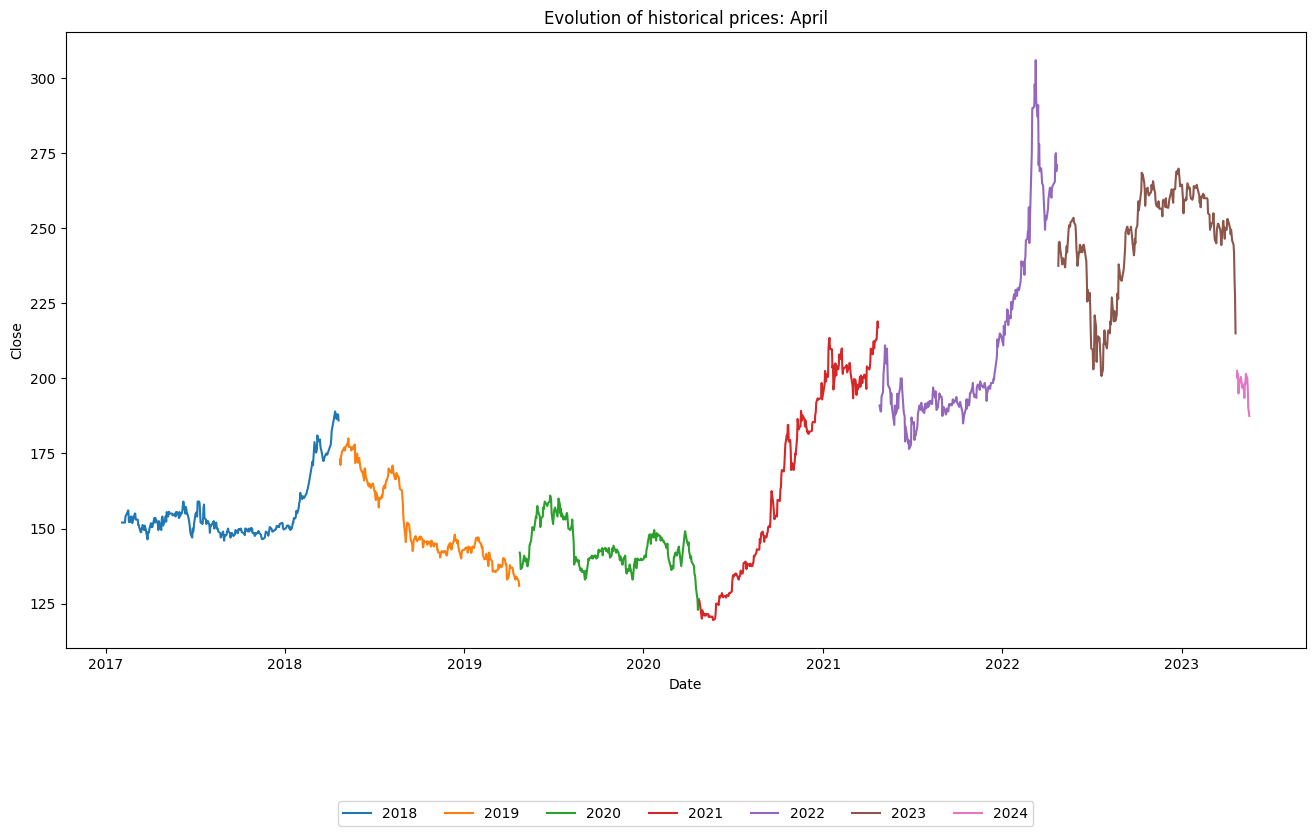

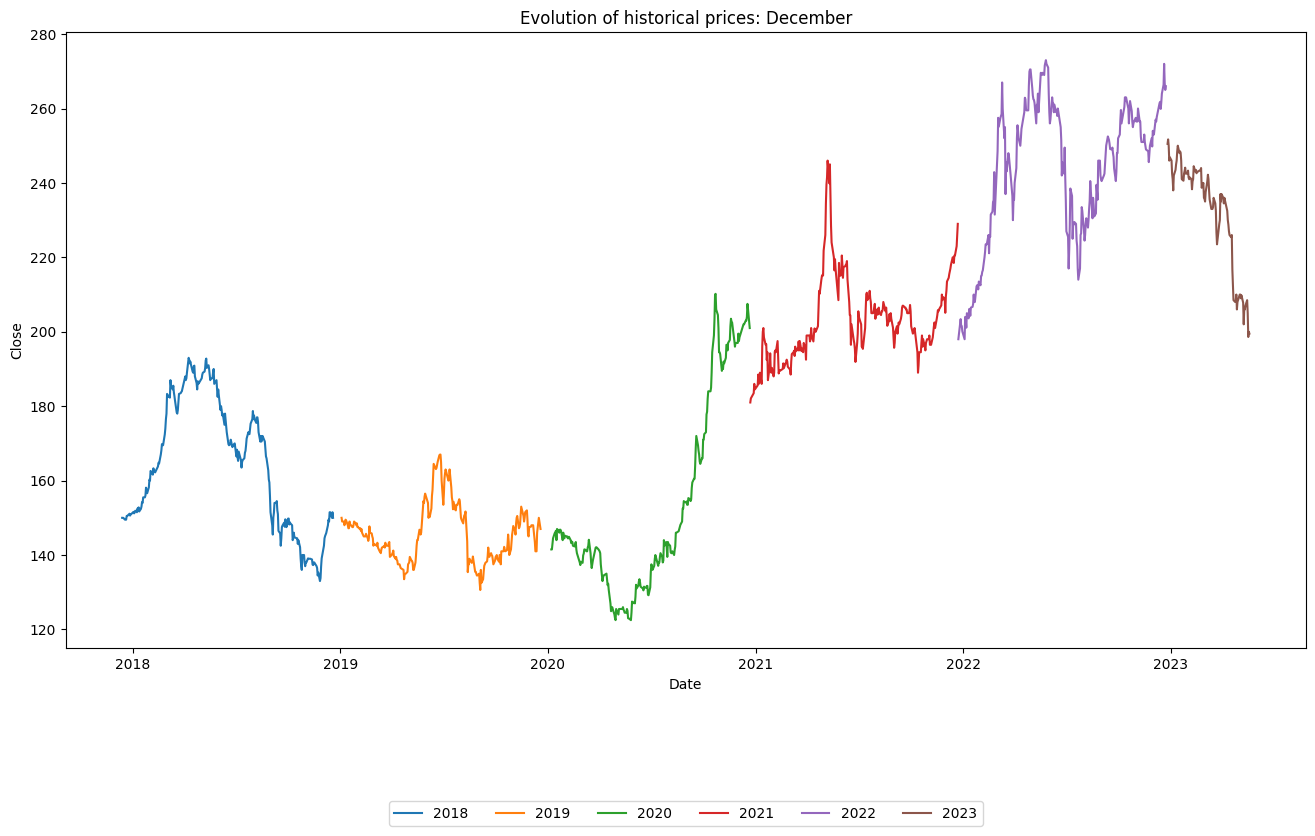

In [88]:
def plot_futures_data(df, month):
    # Create a list of unique expiration values
    expirations = df['expiration'].unique()

    # Create a figure with the desired size
    fig, ax = plt.subplots(figsize=(16, 8))

    # Set style and format
    plt.style.use('default')  # Revert to default style
    ax.set_title('Evolution of historical prices: ' + month)
    ax.set_xlabel('Date')
    ax.set_ylabel('Close')

    # Plot each expiration as a line
    for expiration in expirations:
        df_plot = df[df['expiration'] == expiration]
        ax.plot(df_plot['date'], df_plot['close'], label=str(expiration))

    # Adjust legend position
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=len(expirations))

    # Display the plot
    plt.show()

plot_futures_data(df_1, 'April')
plot_futures_data(df_2, 'December')


## Data merge and spread calculation

In order to merge the dataframes, we create column names for the two sets based on the product and month. `column_1` is defined as the concatenation of the product name (`prod_1`) and the abbreviated month name, while `column_2` is similarly defined for the second set. Next, we merge the two dataframes, `df_1` and `df_2`, on the 'date' column using the `pd.merge()` function. The merge operation combines the dataframes based on matching dates, resulting in a single dataframe, `df`, with both sets of corn futures data. The suffixes, defined as `column_1` and `column_2`, are added to the column names to differentiate between the two sets.

To calculate the spread between two sets of corn futures contracts, we subtract the 'close' values of `column_2` from `column_1`. The calculated spread is stored in a new column named 'spread' within the dataframe `df`. The `pd.to_numeric()` function is used to ensure that the 'close' values are treated as numeric data for accurate subtraction, with any non-numeric values coerced to NaN.

By executing this code, we obtain a merged dataframe `df` that contains the historical price data for both sets of corn futures contracts and the calculated spread. This allows us to further analyze and develop trading strategies based on the price differentials between the two contract months.

In [89]:
# Create column names based on product and month
column_1 = f'_{prod_1}_{calendar.month_name[month_1][:3].lower()}'
column_2 = f'_{prod_2}_{calendar.month_name[month_2][:3].lower()}'

# Merge the two dataframes on 'date' column with appropriate suffixes
df = pd.merge(df_1, df_2, on='date', suffixes=(column_1, column_2))

# Calculate the spread by subtracting the 'close' values of column_2 from column_1
df['spread'] = pd.to_numeric(df['close'+str(column_1)], errors='coerce') - pd.to_numeric(df['close'+str(column_2)], errors='coerce')

df.head()

,date,close_corn_apr,expiration_corn_apr,close_corn_dec,expiration_corn_dec,spread
0,2017-12-13,149.8,2018,150.0,2018,-0.2
1,2017-12-14,150.0,2018,150.0,2018,0.0
2,2017-12-15,150.9,2018,150.0,2018,0.9
3,2017-12-18,150.5,2018,149.5,2018,1.0
4,2017-12-19,150.8,2018,149.5,2018,1.3


## Filter the data

When comparing prices of contracts from different months, there are two key scenarios to consider:

1. **Comparing contracts within the same year**: For instance, we may compare contracts like July 2023 and April 2023. In such cases, our analysis focuses solely on capturing price differences between these specific months within a single year.

2. **Comparing contracts across different years**: Let's take the example of comparing April 2024 and December 2023 contracts. This scenario involves comparing months from different years. To accurately analyze a calendar spread strategy with such variations, it is essential to filter out spread values associated with contracts from the same year.

In this case, analyzing a calendar spread strategy that involves months of a different year (April 2024 vs December 2023) we must filter the observed spread values whose contracts are from the same year. By applying this filtering approach, we ensure that our analysis examines the precise price differentials between the desired contract months.

In [90]:
# Create an empty list to store spread names
spread_names = []

# Iterate over each index in the dataframe
for index in df.index:
    # Construct the spread name using various components
    spread_name = str(prod_1) + '_' + calendar.month_name[month_1].lower() + '_' + str(df.iloc[index,2]) + '_vs_' + str(prod_2) + '_' + calendar.month_name[month_2].lower() + '_' + str(df.iloc[index,4])
    # Append the spread name to the list
    spread_names.append(spread_name)

# Assign the spread names to the 'spread_name' column in the dataframe
df['spread_name'] = spread_names

# Create a mask to compare the expiration values of column_1 and column_2
mask = df['expiration'+str(column_1)] == df['expiration'+str(column_2)]
# In case of analyzing contracts within the same year, replace by the line of code:
# mask = df['expiration'+str(column_1)] != df['expiration'+str(column_2)]

# Drop rows from the dataframe where the expiration values match
df = df.drop(df[mask].index)

# Return the modified dataframe
df.head()

,date,close_corn_apr,expiration_corn_apr,close_corn_dec,expiration_corn_dec,spread,spread_name
86,2018-04-23,173.0,2019,186.2,2018,-13.2,corn_april_2019_vs_corn_december_2018
87,2018-04-24,171.2,2019,184.5,2018,-13.3,corn_april_2019_vs_corn_december_2018
88,2018-04-25,174.0,2019,186.7,2018,-12.7,corn_april_2019_vs_corn_december_2018
89,2018-04-26,174.5,2019,186.0,2018,-11.5,corn_april_2019_vs_corn_december_2018
90,2018-04-27,175.6,2019,186.2,2018,-10.6,corn_april_2019_vs_corn_december_2018


We can plot the dataframe to visualize the historical spreads of each combination of contracts using Matplotlib.

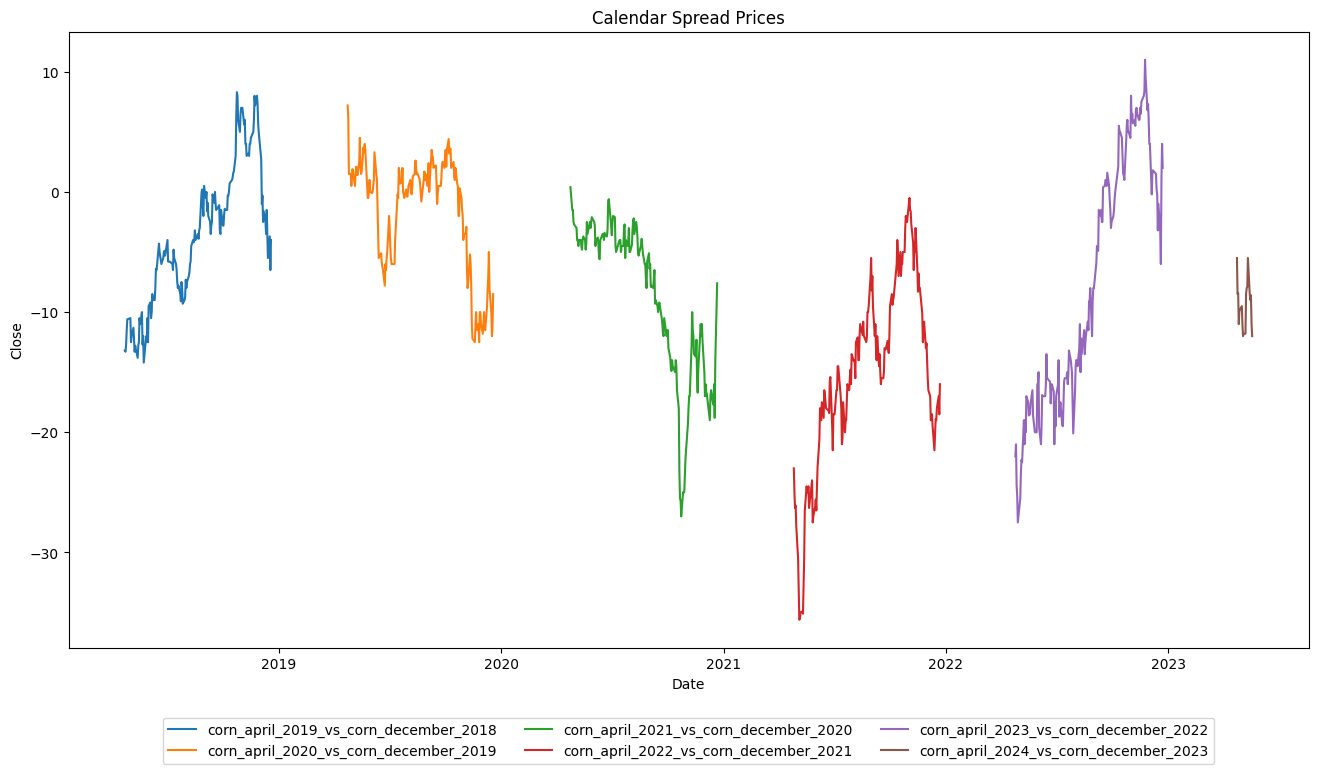

In [91]:
import matplotlib.pyplot as plt

def plot_calendar_spread_data(df):
    # Create a list of unique spread_name values
    spread_names = df['spread_name'].unique()

    # Create a figure with the desired size
    fig, ax = plt.subplots(figsize=(16, 8))

    # Set style and format
    plt.style.use('default')  # Revert to default style
    ax.set_title('Calendar Spread Prices')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close')

    # Plot each spread_name as a line
    for name in spread_names:
        df_plot = df[df['spread_name'] == name]
        ax.plot(df_plot['date'], df_plot['spread'], label=str(name))

    # Adjust legend position
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)

    # Display the plot
    plt.show()

plot_calendar_spread_data(df)


As we can see in the previous graph, we can readily discern a distinct pattern in the spread values during the years 2018, 2021, and 2022. The pattern reveals an upward trend from April to November, followed by a subsequent decline towards December.

In contrast, the years 2019 and 2020 exhibit a contrasting behavior in the spreads. Notably, during October and November, there is a noticeable decrease in the spread values, setting these years apart from the aforementioned pattern.

These observations shed light on the dynamic nature of the spread values across different years, providing valuable insights for our analysis of calendar spread strategy. Now that we know more about the behavior of the spread in past years, let's use this information to forecast the value of the spread in the coming months to analyze a possible calendar spread strategy.

## Forecast future values using Meta Prophet

Prophet, a widely adopted forecasting tool, is highly suitable for analyzing the calendar spread strategy of corn futures. This powerful procedure utilizes an additive model to forecast time series data. It excels in capturing non-linear trends by incorporating yearly, weekly, and daily seasonality, alongside holiday effects.

Prophet shines when applied to time series data with prominent seasonal patterns and a substantial historical dataset spanning multiple seasons. Its strength lies in its ability to handle missing data gracefully and adapt to shifts in the trend. Furthermore, Prophet exhibits robust performance in handling outliers, ensuring accurate and reliable forecasts.

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast. We start from the analyzed dataframe to transform it to the format required by Prophet

In [92]:
# Create an empty DataFrame df_obs
df_obs = pd.DataFrame()

# Assign the 'date' column from df to 'ds' column in df_obs
df_obs['ds'] = df['date']

# Assign the 'spread' column from df to 'y' column in df_obs, converting it to float
df_obs['y'] = df['spread'].astype(float)

# Display the first few rows of df_obs
df_obs.head()

,ds,y
86,2018-04-23,-13.2
87,2018-04-24,-13.3
88,2018-04-25,-12.7
89,2018-04-26,-11.5
90,2018-04-27,-10.6


We initialize the Prophet model by creating an instance, denoted as `m`. Once the model is instantiated, we proceed to fit it to our dataset, `df_obs`. Fitting the model involves training it on the historical data, enabling the model to learn the underlying patterns and dynamics of the corn futures market. This step is crucial for the Prophet model to generate accurate forecasts based on the observed data.

In [93]:
# Create a Prophet instance
m = Prophet()

# Fit the Prophet model to the observed data
m.fit(df_obs)

01:37:53 - cmdstanpy - INFO - Chain [1] start processing
01:37:53 - cmdstanpy - INFO - Chain [1] done processing


Then, we generate a future dataframe to facilitate forecasting using the previously fitted Prophet model. By creating this future dataframe, we extend the time horizon beyond the observed data, allowing us to make predictions for an additional 200 periods into the future.

In [94]:
# Create a future dataframe with 200 additional periods
future = m.make_future_dataframe(periods=200)

# Display the last few rows of the future dataframe
future.tail()

,ds
1032,2023-12-01
1033,2023-12-02
1034,2023-12-03
1035,2023-12-04
1036,2023-12-05


Finally, we utilize the previously fitted Prophet model to generate forecasts for the future timeframe using the future dataframe. By invoking the `predict()` function from the Prophet model, we generate a forecast based on the future dataframe. This function applies the trained model to the future data, leveraging the learned patterns and seasonality to project the expected values of the target variable. In this case, we are interested in forecasting the price of corn futures for the next 200 days.

The resulting forecast object contains various columns, including 'ds' (representing the dates), 'yhat' (the predicted values), 'yhat_lower' (the lower bound of the prediction), and 'yhat_upper' (the upper bound of the prediction). By selecting the last few rows of these columns using tail(), we can examine the forecasted values for the future dates.

In [95]:
# Generate the forecast using the trained model
forecast = m.predict(future)

# Select the desired columns from the forecast dataframe
forecast_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the last few rows of the forecast data
forecast_data.tail()

,ds,yhat,yhat_lower,yhat_upper
1032,2023-12-01,8.000973,1.354803,14.680376
1033,2023-12-02,2.122852,-4.668067,8.700447
1034,2023-12-03,1.700832,-5.537893,8.496809
1035,2023-12-04,6.861594,-0.255803,14.043599
1036,2023-12-05,6.329452,-0.570262,13.167893


By utilizing the `plot_forecast_data()` function, we can represent the predicted values in an engaging manner

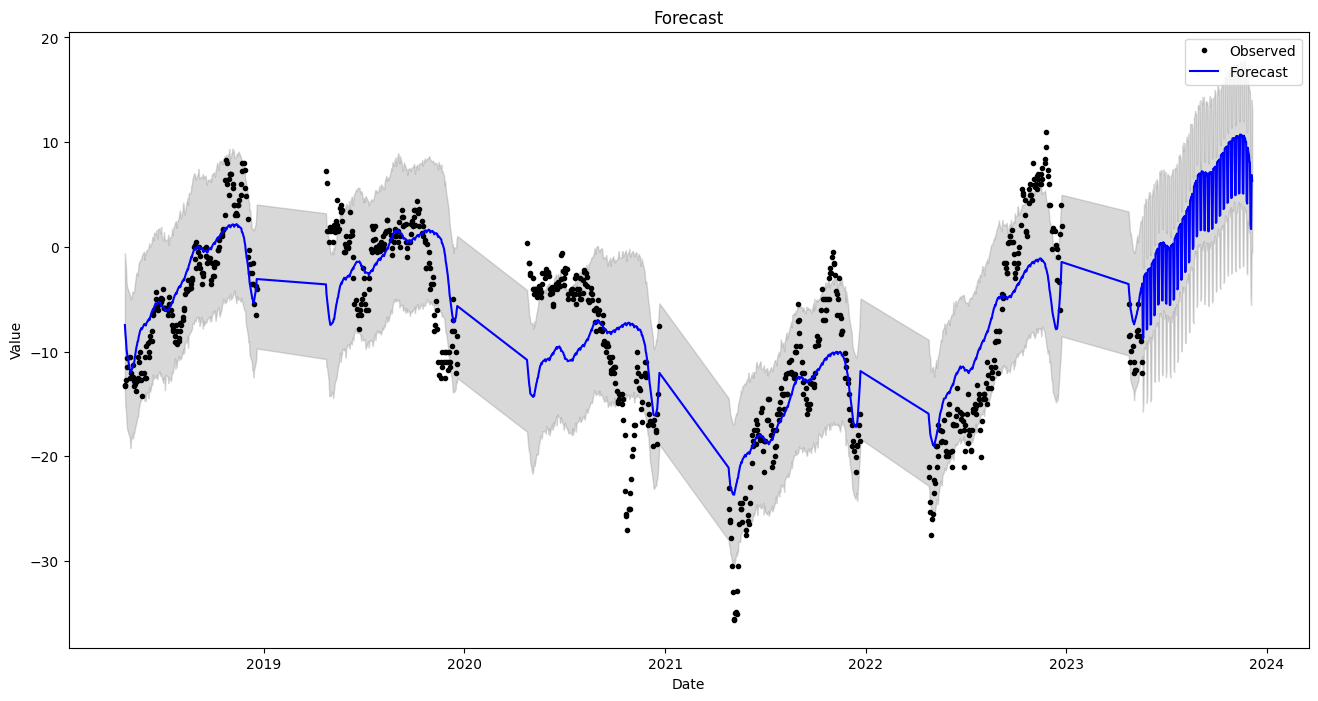

In [96]:
def plot_forecast_data(m, forecast):
    # Create a figure with the desired size
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot the observed data
    ax.plot(m.history['ds'], m.history['y'], 'k.', label='Observed')

    # Plot the forecasted values
    ax.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast')

    # Plot the uncertainty interval
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.3)

    # Set style and format
    plt.style.use('default')  # Revert to default style
    ax.set_title('Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

    # Display the plot
    plt.show()

plot_forecast_data(m, forecast)


To enhance the visualization of the forecasts, we can apply a simple yet effective technique known as smoothing. By implementing a moving average with a window size of 7 periods, we can achieve a smoother representation of the forecasted values. The moving average calculates the average of a specific number of consecutive periods, in this case, 7 periods. By taking the average, we can reduce the impact of short-term fluctuations and highlight the underlying trends in the data.

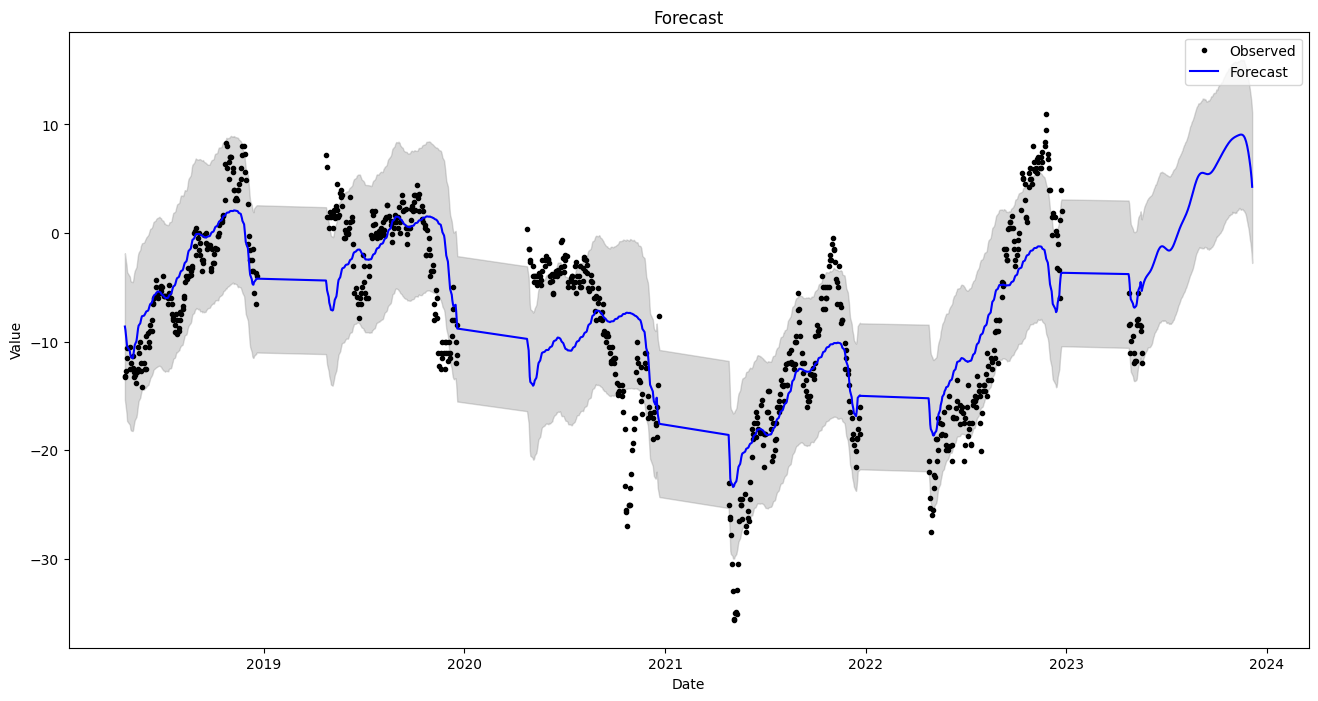

In [97]:
smoothed_forecast = pd.DataFrame()

smoothed_forecast['ds'] = forecast['ds']

# Smooth the 'yhat', 'yhat_lower', and 'yhat_upper' columns using a rolling mean with window size 7
smoothed_forecast['yhat'] = forecast['yhat'].rolling(window=7, min_periods=1, center=True).mean()
smoothed_forecast['yhat_lower'] = forecast['yhat_lower'].rolling(window=7, min_periods=1, center=True).mean()
smoothed_forecast['yhat_upper'] = forecast['yhat_upper'].rolling(window=7, min_periods=1, center=True).mean()

plot_forecast_data(m, smoothed_forecast)


Upon visual analysis of the forecast graph generated with Prophet, we observe a discernible pattern in the predicted values. Looking ahead for the next few months, there is a noticeable upward trend until November, followed by a subsequent decline towards December. This pattern aligns closely with the historical trends observed in previous years, suggesting a consistent behavior in the calendar spread strategy for corn futures. By recognizing and understanding these patterns, we can gain valuable insights to inform our trading decisions and optimize our strategies accordingly.

## Trend and seasonality analysis

Additionally, by invoking the `plot_components_data()` function, we can explore the distinct components of the forecast, including trends, seasonality, and any holiday effects. This visual representation, allows us to examine each component separately and gain insights into their contributions to the overall forecasted values.

Analyzing the trend component helps us identify the long-term direction of the forecast, while examining the seasonality component uncovers any recurring patterns or periodic fluctuations. Additionally, understanding the impact of holiday effects enables us to account for any anomalies or deviations that occur during specific time periods.

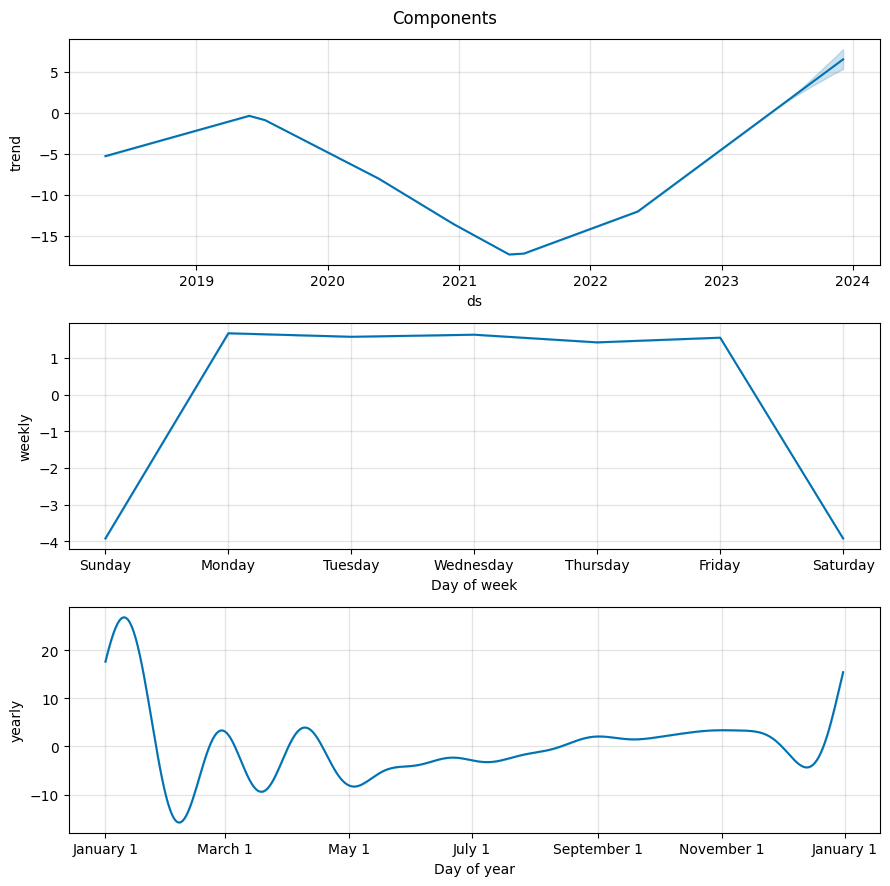

In [98]:
def plot_components_data(m, forecast):
    # Plot the trend component
    fig = m.plot_components(forecast)
    plt.suptitle('Components')
    plt.tight_layout()

    # Display the plot
    plt.show()

plot_components_data(m, forecast)

When examining the long-term trend, we can identify interesting patterns in the data. Between the years 2018 and 2019, we observe a gradual increase in the trend component, transitioning from -5 to 0. However, since 2019 there is a significant downward movement until mid-2021, with values plummeting to -17. Since then, the trend has been on a steady rise, currently hovering around zero. The forecasted values for the upcoming months continue this upward trajectory, reaching a peak of 6.5 in December.

As for the monthly seasonal component, we should note that the observations begin in April of each year. At the start of the year, there are some noticeable fluctuations; however, these should be disregarded due to the limited data available. In April, the monthly seasonal component is around 3.5. It then dips to -8 in May, recovers its previous levels, experiences a slight decline towards early December, and undergoes a sharp increase in the final month.

Regarding the weekly component, no discernible pattern emerges. It's worth noting that trading of the asset does not take place on Saturdays and Sundays, making these days irrelevant in our analysis.

## Conclusions

Based on the generated forecasts, it appears favorable to consider a long position for the strategy. This involves purchasing an April 2024 contract and simultaneously selling a December 2023 contract, aiming to capitalize on potential increases in the price differential between the two.

However, it's essential to emphasize that the analysis conducted here should not be construed as an investment recommendation. It's crucial to acknowledge that the forecast solely relies on historical observations and does not encompass other factors that may impact the spread's price. Nevertheless, the analysis provides a foundation for exploring a potential calendar spread strategy.

Remember, it's prudent to conduct further research, consider additional market factors, and assess your individual risk tolerance and investment objectives before making any trading decisions.